In [1]:
import numpy as np
import pandas as pd
from random import sample

from coremdlr.config import defaults
from coremdlr.datasets.utils import infer_test_wells

from coremdlr.models import FeaturePredictor, LambdaModel
from coremdlr.datasets import WellLoader, FaciesDataset

Using TensorFlow backend.


In [2]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

In [3]:
fmodel_args = {
    'logs': {
        'model': 'LambdaModel',
        'model_args': {'feature': 'logs'}
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def make_params_usable(params):
    """
    Convert params returned by hyperopt to usable `model_args`
    """
    return {
        **XGB_SEARCH_SPACE,
        **params,
        **{'max_depth' : int(params['max_depth']),
           'n_estimators' : int(params['n_estimators'])}
    }

In [15]:
def run_experiment(num_train, max_evals=10, search_space=XGB_SEARCH_SPACE):
    
    assert num_train in [3, 6, 9], 'Must use one of predefined train/test splits'
    
    train_sets = getattr(defaults, f'TRAIN_SETS_{num_train}')
    
    datasets = [FaciesDataset(s, infer_test_wells(s), features=['logs']) for s in train_sets]
    
    for dset in datasets:
        dset.load_or_generate_data()
    
    def train_model(model_config):
        
        log_losses = []
        
        for dset in datasets:
            
            model = FeaturePredictor(dset, model_args=model_config, feature_model_args=fmodel_args)
            model.fit(dset, verbose=False)
            print('F1 score:', f1_score(dset.y_test, model.predict(dset.X_test), average='macro'))
            
            log_losses.append(log_loss(dset.y_test, model.predict_proba(dset.X_test), 
                                      sample_weight=compute_sample_weight('balanced', dset.y_test)))
            
        return np.mean(log_losses)
    
    return hyperopt.fmin(
        fn=train_model,
        space=XGB_SEARCH_SPACE,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals
    )

In [16]:
best_params_3 = run_experiment(3)

print('\n\n\t Starting TRAIN_SET_6')
best_params_6 = run_experiment(6)

print('\n\n\t Starting TRAIN_SET_9')
best_params_9 = run_experiment(9)

Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Training model for feature:  logs
F1 score: 0.19649103088489403
Training model for feature:  logs
F1 score: 0.20348311560692317
Training model for feature:  logs
F1 score: 0.2108244552906698
Training model for feature:  logs
F1 score: 0.2040251125858164
Training model for feature:  logs
F1 score: 0.18884030009795574
Training model for feature:  logs
F1 score: 0.21008999001982684
Training model for feature:  logs
F1 score: 0.2238222904992037
Training model for feature:  logs
F1 score: 0.21243464919736987
Training model for feature:  logs
F1 score: 0.19720413133621623
Training model for feature:  logs
F1 score: 0.23489329076606494
Training model for feature:  logs
F1 score: 0.19247378381396635
Training model for feature:  logs
F1 score: 0.19653005706718601
Training model for feature:  logs
F1 score: 0.24206682254880843
Training model for feature:  logs
F1 score: 0.1972110027033646
Trainin

Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Training model for feature:  logs
F1 score: 0.21485534088353542
Training model for feature:  logs
F1 score: 0.16447748036956242
Training model for feature:  logs
F1 score: 0.11527369652082713
Training model for feature:  logs
F1 score: 0.19978095392349035
Training model for feature:  logs
F1 score: 0.1702833323990156
Training model for feature:  logs
F1 score: 0.11904697364119683
Training model for feature:  logs
F1 score: 0.23416192826883572
Training model for feature:  logs
F1 score: 0.15967024786587566
Training model for feature:  logs
F1 score: 0.12584691051511415
Training model for feature:  logs
F1 score: 0.23179416840308953
Training model for feature:  logs
F1 score: 0.1633154014643768
Training model for feature:  logs
F1 score: 0.13730464324743993
Training model for feature:  logs
F1 score: 0.21400842332020842
Training model for feature:  logs
F1 score: 0.163662

Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Training model for feature:  logs
F1 score: 0.14166930426540317
Training model for feature:  logs
F1 score: 0.23874602518279583
Training model for feature:  logs
F1 score: 0.27821915026592386
Training model for feature:  logs
F1 score: 0.1529223915629262
Training model for feature:  logs
F1 score: 0.2397779160513009
Training model for feature:  logs
F1 score: 0.2791934498988608
Training model for feature:  logs
F1 score: 0.13986143408448087
Training model for feature:  logs
F1 score: 0.24848473361324844
Training model for feature:  logs
F1 score: 0.2695345637559738
Training model for feature:  logs
F1 score: 0.12818314303890171
Training model for feature:  logs
F1 score: 0.29620068686603984
Training model for feature:  logs
F1 score: 0.2491172092291932
Training model for feature:  logs
F1 score: 0.1459216458067332
Training model for feature:  logs
F1 score: 0.2458823847

In [4]:
best_params_3 = {'colsample_bytree': 0.715782636188357,
 'gamma': 0.38031439765997715,
 'learning_rate': 0.13285585695446292,
 'max_depth': 3.0,
 'n_estimators': 107.0,
 'reg_lambda': 7.063383010063417,
 'subsample': 0.5627460184070672}

In [5]:
best_params_6 = {'colsample_bytree': 0.5044540258165737,
 'gamma': 0.3606833915563988,
 'learning_rate': 0.020567898195521434,
 'max_depth': 8.0,
 'n_estimators': 278.0,
 'reg_lambda': 5.316977094203006,
 'subsample': 0.6810694533283663}

In [6]:
best_params_9 = {'colsample_bytree': 0.4845409209422611,
 'gamma': 0.4368302424155825,
 'learning_rate': 0.11360839815510773,
 'max_depth': 3.0,
 'n_estimators': 90.0,
 'reg_lambda': 8.283549867329606,
 'subsample': 0.9353591985992722}

In [7]:
def pred_results_df(num_train, model_config):
    
    assert num_train in [3, 6, 9], 'Must use one of predefined train/test splits'
    
    train_sets = getattr(defaults, f'TRAIN_SETS_{num_train}')
    
    datasets = [FaciesDataset(s, infer_test_wells(s), features=['logs']) for s in train_sets]
    
    pred_dfs = []
    
    for i, dset in enumerate(datasets):
        dset.load_or_generate_data()
        
        model = FeaturePredictor(dset, model_args=model_config, feature_model_args=fmodel_args)
        model.fit(dset, verbose=False)
        
        print('predict_proba: ', model.predict_proba(dset.X_test))
        
        for test_well_name in dset.test_well_names:
            df = model.preds_dataframe(test_well_name, logs=dset.logs_args['which_logs'])
            df['well'] = test_well_name
            df['set_number'] = i
            pred_dfs.append(df)
        
    return pd.concat(pred_dfs)

In [8]:
preds_df_3 = pred_results_df(3, make_params_usable(best_params_3))
preds_df_3

Loading Well:  204-24a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (19294,)), ('top', (19294,)), ('base', (19294,)), ('logs', (19294, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('logs', (13006, 11))]
Loading Well:  204-20-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (10906,)), ('top', (10906,)), ('base', (10906,)), ('logs', (10906, 11))]
Loading Well:  204-20-2  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Feature shapes:  [('depth', (2940,)), ('top', (2940,)), ('base', (2940,)), ('logs', (2940, 11))]
Loading Well:  204-19-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9807,)), ('top', (9807,)), ('base', (9807,)), ('logs', (9807, 11))]
Loading Well:  204-20a-7  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3105,)), ('top', (3105,)), ('base', (3105,)), ('logs', (3105, 11))]
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('logs', (3842, 11))]
Loading Well:  204-19-3A  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (9590,)), ('top', (9590,)), ('base', (9590,)), ('logs', (9590, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (3542,)), ('top', (3542,)), ('base', (3542,)), ('logs', (3542, 11))]
Loading Well:  204-20-1  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (11210,)), ('top', (11210,)), ('base', (11210,)), ('logs', (11210, 11))]
Loading Well:  204-20-1Z  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (1917,)), ('top', (1917,)), ('base', (1917,)), ('logs', (1917, 11))]
Loading Well:  204-19-6  from  /home/administrator/Dropbox/core_data/facies/train_data


Header section Parameter regexp=~P was not found.


Adding NaN log:  DTS
Feature shapes:  [('depth', (1884,)), ('top', (1884,)), ('base', (1884,)), ('logs', (1884, 11))]
Training model for feature:  logs
predict_proba:  [[0.0703689  0.04174336 0.0202027  0.86212075 0.00556432]
 [0.13455114 0.03886138 0.0188079  0.80259943 0.00518016]
 [0.13794863 0.03984265 0.02238607 0.7950831  0.00473952]
 ...
 [0.5436742  0.0369724  0.01005696 0.33052832 0.07876816]
 [0.42421865 0.045536   0.01586289 0.40708575 0.10729673]
 [0.42421865 0.045536   0.01586289 0.40708575 0.10729673]]
probas:  [[0.0703689  0.04174336 0.0202027  0.86212075 0.00556432]
 [0.13455114 0.03886138 0.0188079  0.80259943 0.00518016]
 [0.13794863 0.03984265 0.02238607 0.7950831  0.00473952]
 ...
 [0.5138081  0.08241984 0.23292023 0.01152381 0.15932809]
 [0.47539118 0.08302867 0.272544   0.01160893 0.15742727]
 [0.46466884 0.08115599 0.26639682 0.01134709 0.17643125]]
probas:  [[0.14418636 0.06771827 0.6161723  0.12160584 0.05031722]
 [0.14418636 0.06771827 0.6161723  0.12160584 0.

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
pred_dfs = []

for test_well_name in fdset.test_well_names:
    df = xgb_predictor.preds_dataframe(test_well_name, logs=fdset.logs_args['which_logs'])
    df['well'] = test_well_name
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot(df, fdset.classes, title=test_well_name, ax=ax)
    
    pred_dfs.append(df)
    
pred_df = pd.concat(pred_dfs)

In [7]:
best_params

params = {
    **XGB_SEARCH_SPACE, 
    **best_params, 
    **{'max_depth' : int(best_params['max_depth']), 
       'n_estimators' : int(best_params['n_estimators'])}
}
xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=fmodel_args)
xgb_predictor.fit(fdset, verbose=True)



imps = list(zip(fdset.wells[0].logs_args['which_logs'], xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
for pair in imps[::-1]:
    print(pair)

Training model for feature:  logs
                      precision    recall  f1-score   support

           sandstone       0.21      0.31      0.25        54
clay-prone sandstone       0.06      0.65      0.11        20
      sandy mudstone       0.07      0.41      0.12        17
          oilstained       0.00      0.00      0.00       140
            mudstone       0.73      0.06      0.12       170

           micro avg       0.12      0.12      0.12       401
           macro avg       0.22      0.29      0.12       401
        weighted avg       0.35      0.12      0.10       401
 
Total accuracy Score :  0.11970074812967581
Confusion Matrix: 
 [[ 17  25  11   0   1]
 [  2  13   5   0   0]
 [  2   8   7   0   0]
 [ 54  57  26   0   3]
 [  6 107  46   0  11]]
('SP', 0.17077033)
('GR', 0.11835853)
('PEF', 0.1087113)
('DENS', 0.09805615)
('RDEP', 0.08610511)
('DTC', 0.08264939)
('RSHAL', 0.074298054)
('DTS2', 0.0737221)
('DTS', 0.06940245)
('DTS1', 0.067674585)
('NEUT', 0.05025198)

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
# savefilename = str(test_well[0])+"_"+str(num_of_train_wells)+"_trainingwells"+".txt"

savefilename = f'{test_well[0]}_{num_of_train_wells}_trainingwells'

#file = open(savefilename, 'w')
#file.write(str(xgb_predictor.fit(fdset, verbose=True, save_report=savefilename)))
#file.close()

xgb_predictor.fit(fdset, verbose=True, save_report=savefilename)

Training model for feature:  logs


TypeError: fit() got an unexpected keyword argument 'save_report'

In [18]:
savefilename

'204-24a-7_6_trainingwells'

/home/administrator/code/python/coremdlr/coremdlr/viz/__init__.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/administrator

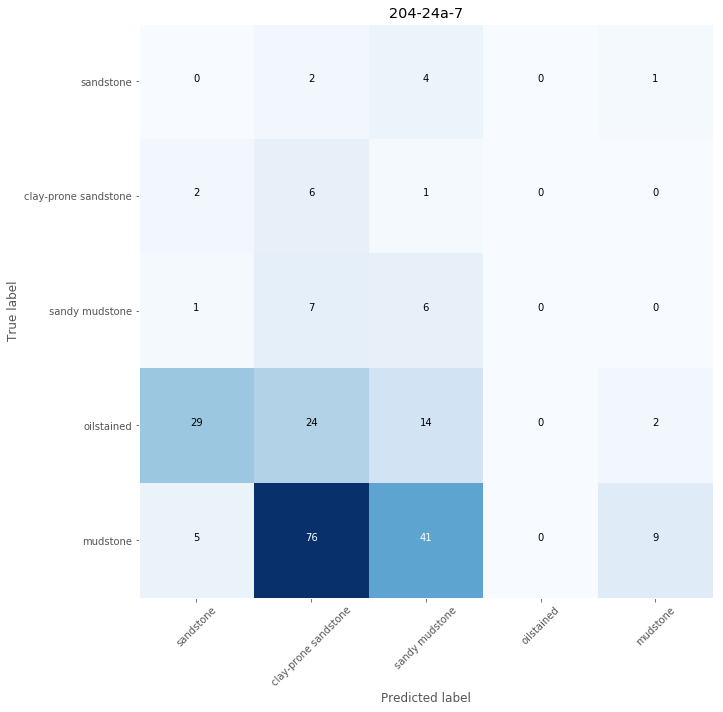

In [16]:
import matplotlib.pyplot as plt
from coremdlr.viz import model_plots 

pred_dfs = []

for test_well_name in fdset.test_well_names:
    df = xgb_predictor.preds_dataframe(test_well_name, logs=fdset.logs_args['which_logs'])
    df['well'] = test_well_name
    
    fig, ax = plt.subplots(figsize=(10,10))
    model_plots.confusion_matrix_plot(df, fdset.classes, title=test_well_name, ax=ax)
    
    pred_dfs.append(df)
    
pred_df = pd.concat(pred_dfs)

In [17]:
ls

204-24a-7_6_trainingwells.txt  xgb_logs_test_resolution.ipynb
preds_204-19-6.csv             xgb_logs_tune.ipynb
rmlp_logs_test.ipynb           xgb_logs_tune-TM.ipynb
XGB_logs_python.py             xgb_pGR_plus_logs.ipynb


['sandstone',
 'clay-prone sandstone',
 'sandy mudstone',
 'oilstained',
 'mudstone']